In [1]:
import pandas as pd

data = pd.read_csv("/content/fluprint_export.csv")

pivot_column = "name"
data.drop(columns='name_formatted', inplace=True)

pivoted = data.pivot_table(
    index=["donor_id", "visit_id"],
    columns=pivot_column,
    values="data",
    aggfunc='first'
).reset_index()

pivoted = pd.merge(pivoted, data.drop_duplicates(subset=["donor_id", "visit_id"]), on=["donor_id", "visit_id"])

columns_to_drop = [pivot_column, "data"]
pivoted = pivoted.drop(columns=[col for col in columns_to_drop if col in pivoted])

pivoted.to_csv("transformed_dataset.csv", index=False)

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import shap
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/content/transformed_dataset.csv')

print(data.head())

   donor_id  visit_id  B cells  BASO %  BASO CT  BDNF  CD16+ monocytes  \
0         1         1     85.9     NaN      NaN  0.10             2.61   
1         2         2      NaN     NaN      NaN  1.44              NaN   
2         3         3     73.2     NaN      NaN -1.19             3.89   
3         4         4      NaN     NaN      NaN -0.55              NaN   
4         5         5     57.7     NaN      NaN  1.22             3.10   

   CD16+CD14+ monocytes  CD16+CD14- monocytes  CD16-CD56bright NK cells  ...  \
0                  1.30                  1.41                      0.35  ...   
1                   NaN                   NaN                       NaN  ...   
2                  3.05                  1.04                      1.67  ...   
3                   NaN                   NaN                       NaN  ...   
4                  1.14                  2.00                      2.71  ...   

   vaccinated_2yr_prior  vaccine_type_2yr_prior  vaccinated_3yr_prior  \
0

In [57]:
vaccine_response = 'vaccine_response'

columns_to_drop = ['donor_id', 'study_id', 'visit_id', 'visit_year', 'visit_day', 'visit_type_hai', 'mesurment_id']
data = data.drop(columns=columns_to_drop)

data = data.dropna(subset=[vaccine_response])

print(data.columns)

Index(['B cells', 'BASO %', 'BASO CT', 'BDNF', 'CD16+ monocytes',
       'CD16+CD14+ monocytes', 'CD16+CD14- monocytes',
       'CD16-CD56bright NK cells', 'CD161+ NK cells', 'CD161+ NKT cells',
       ...
       'vaccinated_2yr_prior', 'vaccine_type_2yr_prior',
       'vaccinated_3yr_prior', 'vaccine_type_3yr_prior',
       'vaccinated_4yr_prior', 'vaccine_type_4yr_prior',
       'vaccinated_5yr_prior', 'vaccine_type_5yr_prior',
       'influenza_infection_history', 'influenza_hospitalization'],
      dtype='object', length=3311)


In [58]:
X = data.drop(vaccine_response, axis=1)
y = data[vaccine_response]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [59]:
model = XGBClassifier(eval_metric='logloss', enable_categorical=True)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

High Responders (1):
Precision: 0.8
Recall: 0.6153846153846154
F1-Score: 0.6956521739130435

Low Responders (0):
Precision: 0.8113207547169812
Recall: 0.9148936170212766
F1-Score: 0.86

Overall Metrics:
Accuracy: 0.8082191780821918
ROC AUC: 0.8723404255319149



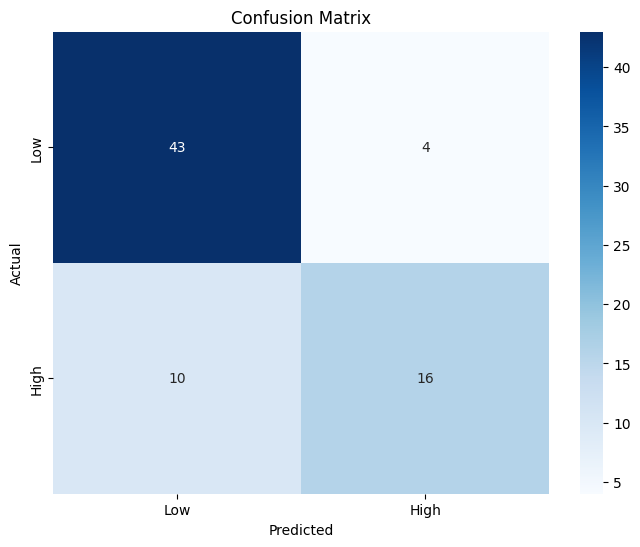


Classification Report:
              precision    recall  f1-score   support

         Low       0.81      0.91      0.86        47
        High       0.80      0.62      0.70        26

    accuracy                           0.81        73
   macro avg       0.81      0.77      0.78        73
weighted avg       0.81      0.81      0.80        73



In [60]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

precision_high = precision_score(y_test, y_pred, pos_label=1)
recall_high = recall_score(y_test, y_pred, pos_label=1)
f1_high = f1_score(y_test, y_pred, pos_label=1)

precision_low = precision_score(y_test, y_pred, pos_label=0)
recall_low = recall_score(y_test, y_pred, pos_label=0)
f1_low = f1_score(y_test, y_pred, pos_label=0)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("High Responders (1):")
print(f"Precision: {precision_high}")
print(f"Recall: {recall_high}")
print(f"F1-Score: {f1_high}")

print("\nLow Responders (0):")
print(f"Precision: {precision_low}")
print(f"Recall: {recall_low}")
print(f"F1-Score: {f1_low}")

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}\n")

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'High']))

In [61]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

mean_abs_shap = shap_values_df.abs().mean().sort_values(ascending=False)

importance_percentage = (mean_abs_shap / mean_abs_shap.sum()) * 100

importance_df = pd.DataFrame(importance_percentage).reset_index()
importance_df.columns = ['Feature', 'Importance (%)']
print(importance_df[:20])

                    Feature  Importance (%)
0                d_geo_mean       22.314323
1                  geo_mean        7.974775
2        CD85j+CD4+ T cells        4.016304
3       CD161+CD45RA+ Tregs        2.182465
4                  L50_IFNB        1.890115
5                 L50_ICAM1        1.813595
6         CD27+CD8+ T cells        1.568877
7                   L50_HGF        1.506532
8   HLADR-CD38+CD4+ T cells        1.475321
9                   B cells        1.459686
10  total_vaccines_received        1.422971
11               L50_RANTES        1.378472
12               L50_PDGFBB        1.236744
13                    Tregs        1.208230
14                L50_IL17F        1.168467
15                monocytes        1.139914
16                   RANTES        1.081454
17                L50_CD40L        1.069806
18      Unstim_CD8+: pSTAT3        0.971132
19   vaccine_type_2yr_prior        0.960934
